In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from imblearn.combine import SMOTETomek 

from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

import prepare
import model

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, f_regression

In [2]:
# acquire dataset
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [3]:
# prepare data using script
df = prepare.prep_data(df).drop(columns=['age_range'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5109 entries, 0 to 5108
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   object 
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   object 
 3   heart_disease      5109 non-null   object 
 4   ever_married       5109 non-null   object 
 5   work_type          5109 non-null   object 
 6   residence_type     5109 non-null   object 
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                5109 non-null   float64
 9   smoking_status     5109 non-null   object 
 10  stroke             5109 non-null   int64  
dtypes: float64(3), int64(1), object(7)
memory usage: 439.2+ KB


In [5]:
# split the dataset into train_validate and test
train_validate, test = train_test_split(df, test_size=.2, random_state=777)

In [6]:
# the second split of train and validate
train, validate = train_test_split(train_validate, test_size=.25, random_state=777)

In [7]:
# checking the shape of each dataset
train.shape, validate.shape, test.shape

((3065, 11), (1022, 11), (1022, 11))

In [8]:
# viewing only up 18 - 25 age range from the data set
mask = (train.age < 25) & (train.age >= 18)
train_subset = train[mask]
train_subset


,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
531,Male,23.0,0,0,No,Private,Rural,93.74,31.2,never smoked,0
4885,Female,21.0,0,0,No,Private,Rural,55.12,21.8,never smoked,0
2820,Female,20.0,0,0,No,Private,Rural,102.42,18.6,never smoked,0
1492,Female,23.0,0,0,No,Private,Rural,65.90,21.5,never smoked,0
4417,Male,18.0,0,0,No,Private,Rural,98.07,24.0,never smoked,0
...,...,...,...,...,...,...,...,...,...,...,...
2832,Male,24.0,0,0,No,Private,Urban,84.16,37.5,smokes,0
858,Female,19.0,0,0,No,Private,Rural,77.19,37.4,smokes,0
3120,Female,23.0,0,0,No,Private,Rural,91.95,23.0,Unknown,0
4412,Male,21.0,0,0,No,Private,Urban,73.81,19.8,Unknown,0


In [9]:
# setting up for boolean masking 
mask1 = (train_subset.stroke == 0)
mask2 = (train_subset.stroke == 1)
has_stroke = train_subset[mask2]
not_stroke = train_subset[mask1]

In [10]:
# perform t-test
stats.mannwhitneyu(has_stroke.avg_glucose_level, not_stroke.avg_glucose_level, alternative = "greater")


/opt/homebrew/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:7171: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


MannwhitneyuResult(statistic=0.0, pvalue=1.0)

In [11]:
has_stroke

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke


In [12]:
train_subset.stroke.value_counts()

0    212
Name: stroke, dtype: int64

### In the age group 18 to 25, there was no incident of stroke

In [13]:
# looking at 40 to 65 age group
mask3 = (train.age < 65) & (train.age >= 40)
train_subset1 = train[mask3]
train_subset1

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
4699,Male,47.0,0,0,Yes,Private,Rural,110.14,30.5,smokes,0
5035,Male,56.0,0,0,Yes,Self-employed,Rural,125.87,24.6,never smoked,0
1695,Male,57.0,0,0,Yes,Private,Rural,70.16,25.8,formerly smoked,0
1459,Female,49.0,0,0,Yes,Govt_job,Rural,83.84,19.3,formerly smoked,0
166,Female,56.0,0,0,Yes,Govt_job,Rural,162.23,27.3,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...
2156,Female,55.0,0,0,Yes,Self-employed,Urban,59.20,43.8,never smoked,0
4736,Female,54.0,0,0,Yes,Govt_job,Urban,231.54,29.9,never smoked,0
1345,Female,47.0,0,0,Yes,Private,Urban,112.09,24.7,smokes,0
2903,Male,63.0,0,0,Yes,Private,Rural,104.79,24.1,Unknown,0


In [14]:
train_subset1.stroke.value_counts()

0    1099
1      52
Name: stroke, dtype: int64

In [15]:
mask3 = (train_subset1.stroke == 0)
mask4 = (train_subset1.stroke == 1)
has_stroke = train_subset1[mask4]
not_stroke = train_subset1[mask3]

In [16]:
stats.mannwhitneyu(has_stroke.avg_glucose_level, not_stroke.avg_glucose_level, alternative = 'greater')


MannwhitneyuResult(statistic=38430.0, pvalue=1.2900358295000951e-05)

### takeaway: 
The age group 40 to 65 that had a stroke has a higer glucose level than those that did not have a stroke.


/opt/homebrew/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='avg_glucose_level', ylabel='Density'>

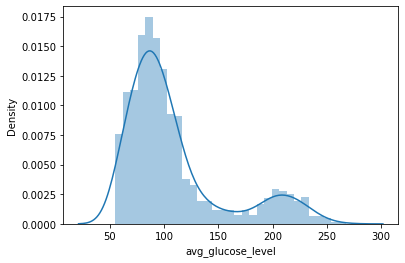

In [23]:
sns.distplot(train_subset1.avg_glucose_level)

In [17]:
# looking at 40 to 65 age group for BMI
maskb = (train.bmi < 65) & (train.bmi >= 40)
train_subset2 = train[maskb]
train_subset2

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
860,Female,46.0,0,0,Yes,Private,Rural,100.15,50.3,smokes,0
2606,Male,42.0,1,0,Yes,Self-employed,Rural,77.24,41.2,Unknown,0
2060,Male,59.0,0,0,Yes,Private,Rural,93.90,42.2,never smoked,0
2111,Male,57.0,1,0,Yes,Private,Urban,80.72,41.5,formerly smoked,0
2284,Male,52.0,1,0,Yes,Self-employed,Rural,192.37,49.2,never smoked,0
...,...,...,...,...,...,...,...,...,...,...,...
834,Female,32.0,0,0,Yes,Private,Rural,85.62,46.1,smokes,0
4125,Female,42.0,0,0,Yes,Private,Urban,74.80,50.6,Unknown,0
3343,Male,41.0,0,0,No,Private,Urban,70.55,44.2,Unknown,0
4224,Female,37.0,0,0,Yes,Private,Rural,77.10,55.9,Unknown,0


In [18]:
train_subset2.stroke.value_counts()

0    227
1     12
Name: stroke, dtype: int64

In [19]:
mask5 = (train_subset2.stroke == 0)
mask6 = (train_subset2.stroke == 1)
has_stroke = train_subset2[mask6]
not_stroke = train_subset2[mask5]

In [20]:
stats.mannwhitneyu(has_stroke.bmi, not_stroke.bmi, alternative = 'greater')



MannwhitneyuResult(statistic=1198.0, pvalue=0.759556206993732)

/opt/homebrew/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='bmi', ylabel='Density'>

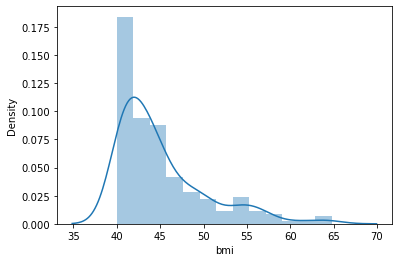

In [22]:
sns.distplot(train_subset2.bmi)